# Census Data

In [1]:
import cenpy
import pandas as pd
import geopandas as gpd
acs = cenpy.remote.APIConnection("ACSDT5Y2015")
alt.data_transformers.enable('json')

NameError: name 'alt' is not defined

In [345]:
censusRace = acs.query(
    cols=["NAME","B02001_001E","B02001_002E"],
    geo_unit="block group:*",
    geo_filter={
                "state" : "42", 
                "county" : "101"
               },
).rename(columns={"B02001_001E": "totalPop","B02001_002E": "whitePop"}, errors="raise")

In [356]:
acs.set_mapservice("tigerWMS_ACS2015")
where_clause = "STATE = 42 AND COUNTY = 101"
censusTract = acs.mapservice.layers[10].query(where=where_clause)
censusTract = censusTract[["STATE","COUNTY","TRACT",'BLKGRP',"geometry"]]
censusTract = censusTract.to_crs(4326)

D:\Miniconda_Python\envs\musa-550-fall-2021\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [359]:
censusTract.shape

(1336, 5)

In [360]:
censusRace2 = censusRace
censusRace2['whitePop'] = pd.to_numeric(censusRace2['whitePop'], errors='ignore')
censusRace2['totalPop'] = pd.to_numeric(censusRace2['totalPop'], errors='ignore')
censusRace2['whitePercep'] = censusRace2['whitePop'] / censusRace2['totalPop'] 
censusRace2['nonwhitePercep'] = 1- censusRace2['whitePercep']
censusRace2.head()

,NAME,totalPop,whitePop,state,county,tract,block group,whitePercep,nonwhitePercep
0,"Block Group 1, Census Tract 81.02, Philadelphi...",858,0,42,101,008102,1,0.000000,1.000000
1,"Block Group 5, Census Tract 81.02, Philadelphi...",894,11,42,101,008102,5,0.012304,0.987696
2,"Block Group 3, Census Tract 81.02, Philadelphi...",543,0,42,101,008102,3,0.000000,1.000000
3,"Block Group 2, Census Tract 248, Philadelphia ...",1109,26,42,101,024800,2,0.023445,0.976555
4,"Block Group 1, Census Tract 2, Philadelphia Co...",2331,911,42,101,000200,1,0.390819,0.609181


In [361]:
censusRace2.shape

(1336, 9)

In [367]:
censusRaceWithGeometry = censusTract.merge(
    censusRace2,
    left_on=["STATE", "COUNTY", "TRACT",'BLKGRP'],
    right_on=["state", "county", "tract",'block group'])
censusRaceWithGeometry = censusRaceWithGeometry.drop(columns=["STATE","COUNTY","TRACT","BLKGRP"])

In [368]:
censusRaceWithGeometry.head()

,geometry,NAME,totalPop,whitePop,state,county,tract,block group,whitePercep,nonwhitePercep
0,"POLYGON ((-75.20223 39.96164, -75.20142 39.961...","Block Group 3, Census Tract 91, Philadelphia C...",1529,223,42,101,009100,3,0.145847,0.854153
1,"POLYGON ((-75.24043 39.96354, -75.24011 39.965...","Block Group 3, Census Tract 95, Philadelphia C...",561,0,42,101,009500,3,0.000000,1.000000
2,"POLYGON ((-75.14683 40.02960, -75.14671 40.030...","Block Group 1, Census Tract 282, Philadelphia ...",1118,21,42,101,028200,1,0.018784,0.981216
3,"POLYGON ((-75.06981 40.07086, -75.06923 40.071...","Block Group 2, Census Tract 337.02, Philadelph...",1598,1010,42,101,033702,2,0.632040,0.367960
4,"POLYGON ((-75.16508 39.91337, -75.16486 39.914...","Block Group 2, Census Tract 372, Philadelphia ...",1454,1196,42,101,037200,2,0.822558,0.177442


In [369]:
censusRaceWithGeometry.to_file('censusRaceWithGeometry.geojson', driver="GeoJSON") 

# 311 Complaints

In [309]:
complaint311 = pd.read_csv ("downloaded_public_cases_fc.csv")

In [310]:
ndService=['Abandoned Vehicle','Graffiti Removal','Vacant House or Commercial','Street Light Outage','Traffic Signal Emergency','Dead Animal in Street', 'Street Defect','Vacant Lot Clean-Up', 'Alley Light Outage', 'Street Trees', 'Abandoned Bike',
       'Complaint (Streets)', 'Street Paving', 'Tree Dangerous']

In [316]:
ndService

['Abandoned Vehicle',
 'Graffiti Removal',
 'Vacant House or Commercial',
 'Street Light Outage',
 'Traffic Signal Emergency',
 'Dead Animal in Street',
 'Street Defect',
 'Vacant Lot Clean-Up',
 'Alley Light Outage',
 'Street Trees',
 'Abandoned Bike',
 'Complaint (Streets)',
 'Street Paving',
 'Tree Dangerous']

In [311]:
complaint311Filter = complaint311.query('service_name in @ndService')
complaint311Filter = complaint311Filter[["service_request_id","service_name","agency_responsible","lat","lon"]].dropna()

In [312]:
complaint311Filter['geometry'] = gpd.points_from_xy(complaint311Filter['lon'], complaint311Filter['lat'])
complaint311Filter = gpd.GeoDataFrame(complaint311Filter, geometry='geometry', crs="EPSG:4326")

In [315]:
complaint311Filter

,service_request_id,service_name,agency_responsible,lat,lon,geometry
0,8997243,Abandoned Vehicle,Police Department,39.911438,-75.176307,POINT (-75.17631 39.91144)
1,8967080,Graffiti Removal,Community Life Improvement Program,39.956295,-75.211248,POINT (-75.21125 39.95629)
2,8967081,Graffiti Removal,Community Life Improvement Program,39.954192,-75.211891,POINT (-75.21189 39.95419)
3,8997258,Vacant House or Commercial,License & Inspections,40.067824,-75.149906,POINT (-75.14991 40.06782)
5,8997338,Vacant House or Commercial,License & Inspections,39.941959,-75.167067,POINT (-75.16707 39.94196)
...,...,...,...,...,...,...
569884,9404728,Alley Light Outage,Streets Department,40.018727,-75.073542,POINT (-75.07354 40.01873)
569885,9079333,Alley Light Outage,Streets Department,40.018727,-75.073542,POINT (-75.07354 40.01873)
569886,9523735,Abandoned Vehicle,Police Department,40.032944,-75.181368,POINT (-75.18137 40.03294)
569888,9165792,Abandoned Vehicle,Police Department,40.007009,-75.173339,POINT (-75.17334 40.00701)


# Crime

In [3]:
import carto2gpd
import matplotlib
import numpy as np
from sklearn.neighbors import NearestNeighbors
import altair as alt
from vega_datasets import data
from altair import datum

In [4]:
url = "https://phl.carto.com/api/v2/sql"
table_name = "incidents_part1_part2"
where = "dispatch_date >= '2015-01-01' AND dispatch_date < '2016-01-01'"
crime = carto2gpd.get(url, table_name, where=where)

In [5]:
crime = crime.drop(columns=["objectid","dc_dist","psa","dc_key","ucr_general","point_x","point_y"])
crime["count"]=1
crime = crime.rename(columns={"text_general_code": "crimeType"}, errors="raise")

In [6]:
total = crime.groupby("crimeType").sum("count").sort_values(by="count",ascending=False)
total = total.reset_index()

alt.Chart(total).mark_bar().encode(
    alt.X('crimeType:N',axis=alt.Axis(labelAngle=90),sort='-y'),
    alt.Y('count:Q'),
    color = alt.value("#F79D46"))

In [7]:
selectedCrimeType = total[0:20].crimeType
selectedCrimeType
selectCrime = crime[crime['crimeType'].isin(selectedCrimeType)]

In [8]:
def get_xy_from_geometry(df): 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    return np.column_stack((x, y))

In [9]:
pointsWithSeg = gpd.read_file("pointsWithSeg.geojson")

pointsWithSegXY = get_xy_from_geometry(pointsWithSeg.to_crs(epsg=3857))
crimeXY = get_xy_from_geometry(selectCrime.to_crs(epsg=3857))

nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(pointsWithSegXY)

Dists, Indices = nbrs.kneighbors(crimeXY)

In [10]:
selectCrime["nearestSVPoint"] = Indices
selectCrime2 = selectCrime[['geometry','cartodb_id','crimeType','count','nearestSVPoint']].merge(pointsWithSeg.drop(columns=["geometry","fid","SEG_ID"]),how="left",left_on="nearestSVPoint",right_index=True)
selectCrime2 = selectCrime2.drop(columns="nearestSVPoint").rename(columns={"pointId": "nearestSVPoint"}, errors="raise")

/Users/zh3n/opt/miniconda3/envs/musa550/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [11]:
selectCrime2 = round(selectCrime2,3)
selectCrime2["crimeTypeValue"] = selectCrime2.crimeType.rank(method="first",pct=True)
selectCrime2 = selectCrime2.rename(columns={"crimeTypeValue": "All"}, errors="raise")

In [373]:
selectCrime2.to_csv('selectCrime2.csv') 

In [12]:
sampleCrime = selectCrime2.groupby('crimeType', group_keys=False).apply(lambda x: x.sample(min(len(x), 200)))
alt.data_transformers.enable('json')

selection = alt.selection_multi(fields=['crimeType'], bind='legend')

chart=alt.Chart(sampleCrime).transform_window(
    index='count()'
).transform_fold(
    ['All','wall', 'lives','building','infrastructure','road','sidewalk','sky','green','transportation']
).transform_joinaggregate(
     min='min(value)',
     max='max(value)',
     groupby=['key']
).transform_calculate(
    minmax_value=(datum.value-datum.min)/(datum.max-datum.min)
).mark_line(size=0.5).encode(
    x=alt.X('key:N',axis=alt.Axis(ticks=False, domain=False,labelAngle=0)),
    y=alt.Y('minmax_value:Q',axis=alt.Axis(ticks=False, domain=False)),
    color=alt.condition(selection,
                        alt.Color('crimeType:N', scale=alt.Scale(scheme='category20b')),
                        alt.value('lightgray')),   
    opacity=alt.condition(selection, alt.value(1), alt.value(0.07)),   
    detail='index:N',
).properties(
    width=1000,
    height=500,
    title="Relationship between street component and crime type"
).configure_view(
    strokeWidth=0
).add_selection(selection).interactive()

chart.encoding.x.title = 'Street Component'
chart.encoding.y.title = 'Normalized porportion'
chart

alt.Chart(...)

In [15]:
print(
chart.to_json()
)

{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.8.1.json",
  "config": {
    "view": {
      "continuousHeight": 300,
      "continuousWidth": 400,
      "strokeWidth": 0
    }
  },
  "data": {
    "format": {
      "type": "json"
    },
    "url": "altair-data-192cb6e3fb8b92ba9b25b1c52a9bb15b.json"
  },
  "encoding": {
    "color": {
      "condition": {
        "field": "crimeType",
        "scale": {
          "scheme": "category20b"
        },
        "selection": "selector001",
        "type": "nominal"
      },
      "value": "lightgray"
    },
    "detail": {
      "field": "index",
      "type": "nominal"
    },
    "opacity": {
      "condition": {
        "selection": "selector001",
        "value": 1
      },
      "value": 0.07
    },
    "x": {
      "axis": {
        "domain": false,
        "labelAngle": 0,
        "ticks": false
      },
      "field": "key",
      "title": "Street Component",
      "type": "nominal"
    },
    "y": {
      "axis": {
        

# creating df for regression
### creating 100m buffer around street view points

In [21]:
pointsWithSeg = gpd.read_file("pointsWithSeg.geojson")
pointsWithSeg = pointsWithSeg.to_crs(3857)
sv_buffer = pointsWithSeg.buffer(100)
sv_buffer = gpd.GeoDataFrame(pointsWithSeg.pointId,geometry=sv_buffer)

In [19]:
crime_geo = crime.geometry.to_crs(3857)

In [20]:
sv_buffer.iloc[7064:7065,]

NameError: name 'sv_buffer' is not defined

### calculating crime number (all crimes) within buffer

In [136]:
crime_by_buffer = gpd.sjoin(sv_buffer,crime_geo.to_frame(),how="left")

In [ ]:
# get counts
counts = crime_by_buffer.groupby('pointId').agg('count')['index_right']
counts.name = "crime_counts"

# join back in to sv points
pointsWithSeg = pointsWithSeg.join(counts,on="pointId")

In [138]:
pointsWithSeg = pointsWithSeg.drop(columns=['fid','SEG_ID','geometry'])
quantile_cols = pointsWithSeg.columns[pointsWithSeg.columns.str.endswith('_q')]
pointsWithSeg = pointsWithSeg.drop(columns=quantile_cols)

In [150]:
pointsWithSeg.to_csv('./correlation_ready.csv')

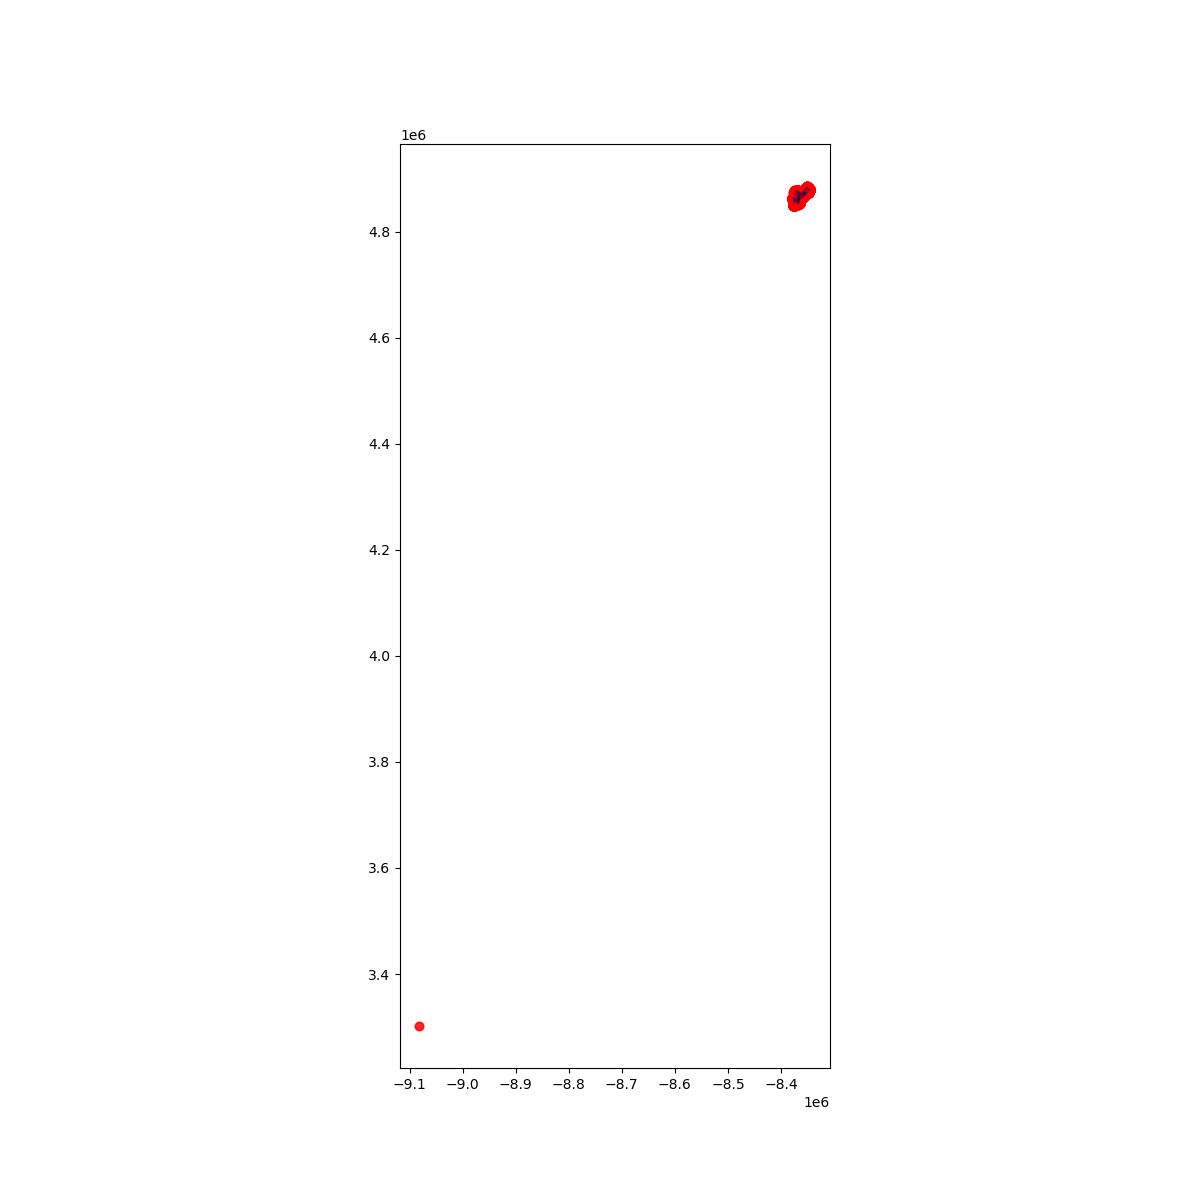

In [22]:
%matplotlib widget
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(12,12))

crime_geo.plot(ax=ax,c="r",alpha=0.2)
sv_buffer.plot(ax=ax,alpha=0.5)
plt.show()

In [26]:
for i,s in enumerate(["a","b"]):
    print(i,s)

0 a
1 b


In [33]:
import ipywidgets as widgets
widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='#333333',
    disabled=False
)

ColorPicker(value='#333333', description='Pick a color')